In [1]:
#import pyrealsense2 as rs
#pipe = rs.pipeline()
#pipe_profile = pipe.start()

#pipe_profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()

In [2]:
test_mp4, test_depth = None, None

In [3]:
test_mp4, test_depth = "./raw_data/rgb_20250708_194127", "./raw_data/depth_20250708_194127"
#test_mp4, test_depth = 'raw_data/raw_rgb_20250708_170252.mp4','raw_data/raw_depth_20250708_170252.avi'

In [4]:
from video_recorder import VideoRecorder
if test_mp4 is None or test_depth is None:
    rec = VideoRecorder()
    test_mp4, test_depth= rec.process_and_write_from_files("./school_data/Korobka/jpg", "./school_data/Korobka/npy", 400)
    print(f"test_mp4, test_depth = '{test_mp4}','{test_depth}'")


In [5]:
"""import cv2
cap = cv2.VideoCapture(test_mp4)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow('Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()"""

"import cv2\ncap = cv2.VideoCapture(test_mp4)\n\nwhile cap.isOpened():\n    ret, frame = cap.read()\n    if not ret:\n        break\n\n    cv2.imshow('Video', frame)\n    if cv2.waitKey(25) & 0xFF == ord('q'):\n        break\n\ncap.release()\ncv2.destroyAllWindows()"

In [6]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera

# Инициализация
camera_intrinsics = {
    'fx': 382.544,
    'fy': 382.544,
    'cx': 320.0,
    'cy': 240.0,
    'depth_scale': 0.001
}

camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth)
processor = FrameProcessor(camera_intrinsics)
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth = camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth)
   
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])
   
   # Или только обработанный RGB с масками
   # cv2.imshow('Processed Video', results['color_with_mask'])
   
   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")
print(f"Отслеживается объектов: {len(processor.tracker.tracked_objects)}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Object 0: создано облако из 7112 точек на основании 12 масок
Object 1: создано облако из 149169 точек на основании 26 масок
[FILTER] Area change too large: 0.57
Object 2: создано облако из 86355 точек на основании 17 масок
Обработано кадров: 91
Отслеживается объектов: 1


In [9]:
import numpy as np
completed_objects = processor.get_completed_objects()
print(f"\nЗавершено объектов: {len(completed_objects)}")

# Анализ результатов
for idx, obj in enumerate(completed_objects):
    print(f"\n Объект №: {idx}")
    print(f"  Точек в облаке: {len(obj['point_cloud'])}")
    print(f"  Всего масок: {len(obj['all_masks'])}")
    print(f"  Выбрано масок: {len(obj['selected_masks'])}")



Завершено объектов: 3

 Объект №: 0
  Точек в облаке: 7112
  Всего масок: 12
  Выбрано масок: 10

 Объект №: 1
  Точек в облаке: 149169
  Всего масок: 26
  Выбрано масок: 10

 Объект №: 2
  Точек в облаке: 86355
  Всего масок: 17
  Выбрано масок: 10


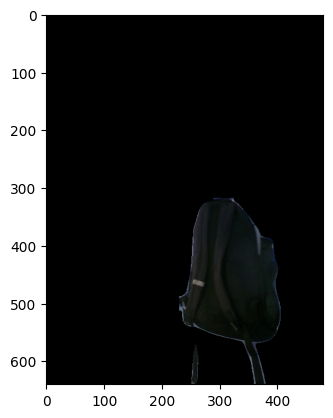

In [14]:
import matplotlib.pyplot as plt
SELECTED_IDX = 1
mask = completed_objects[SELECTED_IDX]['selected_masks'][5]
#mask['rgb_values'].shape
rgb_img = np.zeros((mask['mask'].shape[0], mask['mask'].shape[1], 3), dtype=np.int32)
y_coords, x_coords = np.where(mask['mask'] > 0)
rgb_img[y_coords, x_coords] =mask['rgb_values']
rgb_img.shape
plt.imshow(rgb_img)


[646 646 645 644 644]
[682 682 682 682 682]
[818 817 817 816 816]
[926 927 927 926 926]
[944 945 945 949 949]
[964 964 964 964 963]
[968 968 969 969 970]
[959 961 961   0   0]
[967 968 970 972 974]
[773 767 765 764 762]


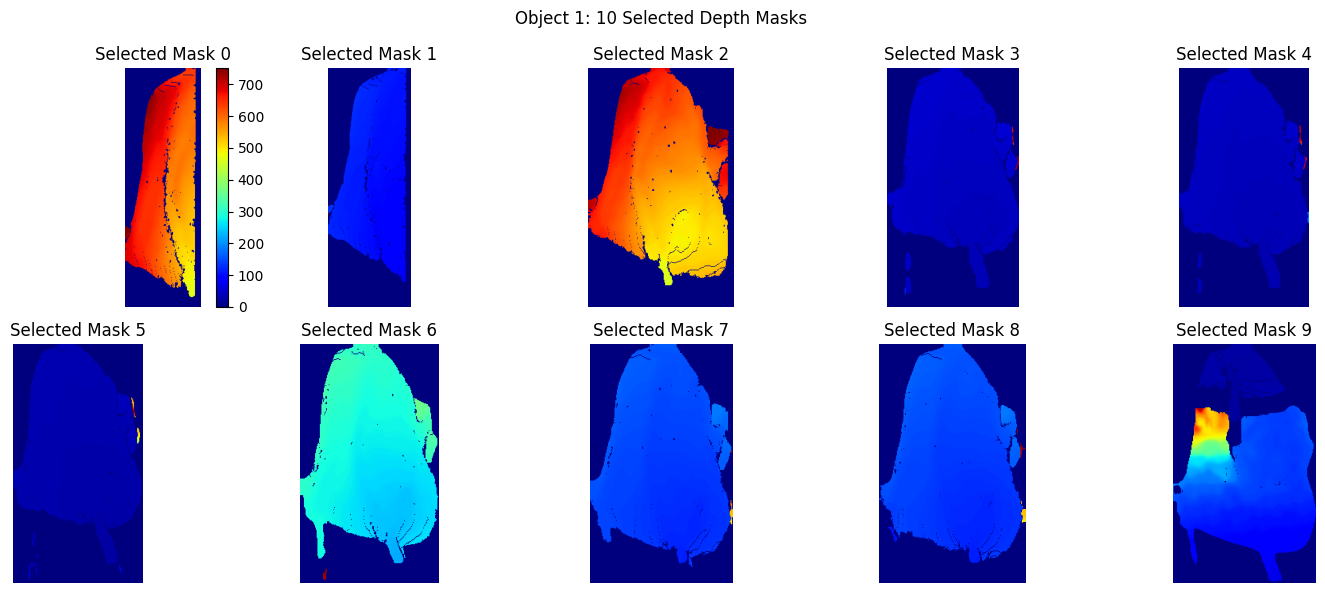

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_depth_masks(obj, show_all=False):
    """Визуализация масок глубины объекта с автоматическим кадрированием"""
    masks_to_show = obj['all_masks'] if show_all else obj['selected_masks']
    n_masks = len(masks_to_show)
    
    cols = min(5, n_masks)
    rows = (n_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.atleast_1d(axes).flatten()

    for i, mask_data in enumerate(masks_to_show):
        if i >= len(axes):
            break

        mask = mask_data['mask']
        depth_values = mask_data['depth_values']
        print(depth_values[:5])
        #rgb_values = mask_data['rgb_values']

        depth_img = np.zeros_like(mask, dtype=np.float32)
        y_coords, x_coords = np.where(mask > 0)
        depth_img[y_coords, x_coords] = depth_values

        # Находим границы непустой области
        if len(x_coords) > 0 and len(y_coords) > 0:
            x_min, x_max = x_coords.min(), x_coords.max()
            y_min, y_max = y_coords.min(), y_coords.max()

            cropped_img = depth_img[y_min:y_max+1, x_min:x_max+1]
        else:
            cropped_img = depth_img  # если маска пустая

        im = axes[i].imshow(cropped_img, cmap='jet')
        axes[i].set_title(f'{"All" if show_all else "Selected"} Mask {i}')
        axes[i].axis('off')

        # Colorbar только для первого изображения
        if i == 0:
            plt.colorbar(im, ax=axes[i], fraction=0.046)

    # Скрыть пустые subplot'ы
    for i in range(n_masks, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'Object {obj["id"]}: {n_masks} {"All" if show_all else "Selected"} Depth Masks')
    plt.tight_layout()
    plt.show()

# Использование
if completed_objects:
   obj = completed_objects[SELECTED_IDX]
   
   # Показать выбранные маски
   visualize_depth_masks(obj, show_all=False)
   
   # Показать все маски
   #visualize_depth_masks(obj, show_all=True)

In [16]:
import plotly.graph_objects as go
import numpy as np

def plot_comparison_plotly(mesh, point_cloud):
    """Сравнение облака точек и меша рядом"""
    from plotly.subplots import make_subplots
    
    # Создаем subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'mesh3d'}]],
        subplot_titles=('Original Point Cloud', 'Reconstructed Mesh')
    )
    
    # Подвыборка точек
    if len(point_cloud) > 5000:
        idx = np.random.choice(len(point_cloud), 5000, replace=False)
        points = point_cloud[idx]
    else:
        points = point_cloud
    
    # Облако точек
    fig.add_trace(
        go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=points[:, 2],
                colorscale='plasma'
            ),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # Меш
    if mesh is not None:
        vertices = np.asarray(mesh.vertices)
        triangles = np.asarray(mesh.triangles)
        
        fig.add_trace(
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=triangles[:, 0],
                j=triangles[:, 1],
                k=triangles[:, 2],
                opacity=0.7,
                color='lightcoral',
                flatshading=True
            ),
            row=1, col=2
        )
        
    # Общие настройки осей
    axis_settings = dict(
        showbackground=True,
        backgroundcolor="rgb(230, 230, 230)",
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)"
    )
    
    fig.update_layout(
        scene1=dict(
            xaxis=axis_settings,
            yaxis=axis_settings,
            zaxis=axis_settings,
            aspectmode='data'
        ),
        scene2=dict(
            xaxis=axis_settings,
            yaxis=axis_settings,
            zaxis=axis_settings,
            aspectmode='data'
        ),
        height=600,
        width=1200
    )
    
    fig.show()


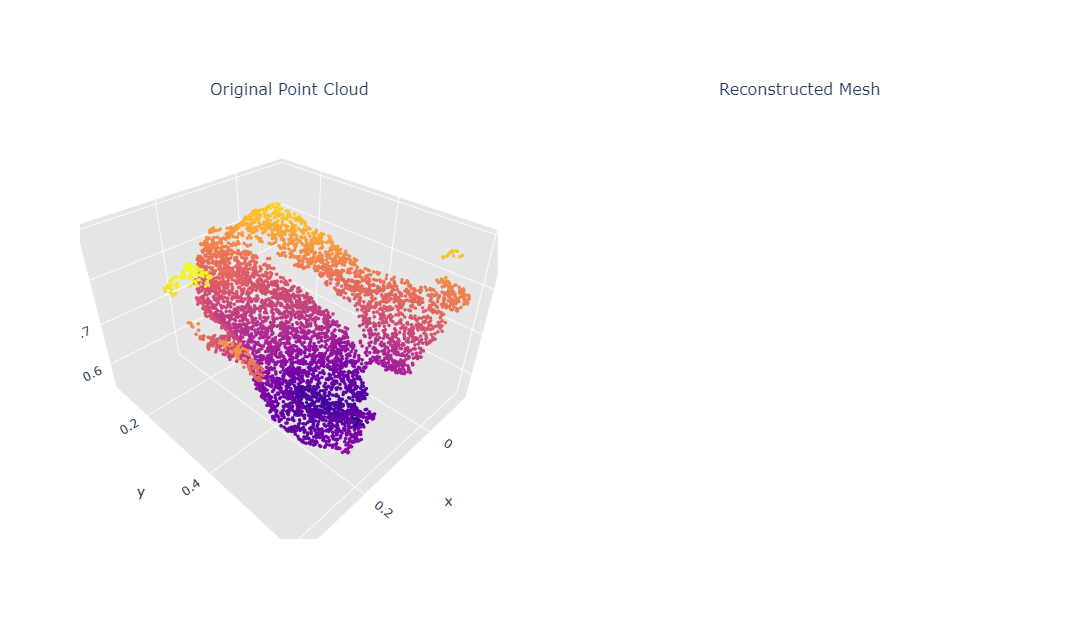

In [18]:
obj= completed_objects[SELECTED_IDX]
plot_comparison_plotly(None, processor.reconstructor.reconstruct_from_masks([obj['selected_masks'][2]]))
#processor.reconstructor.reconstruct_from_masks(obj['selected_masks'][:3])

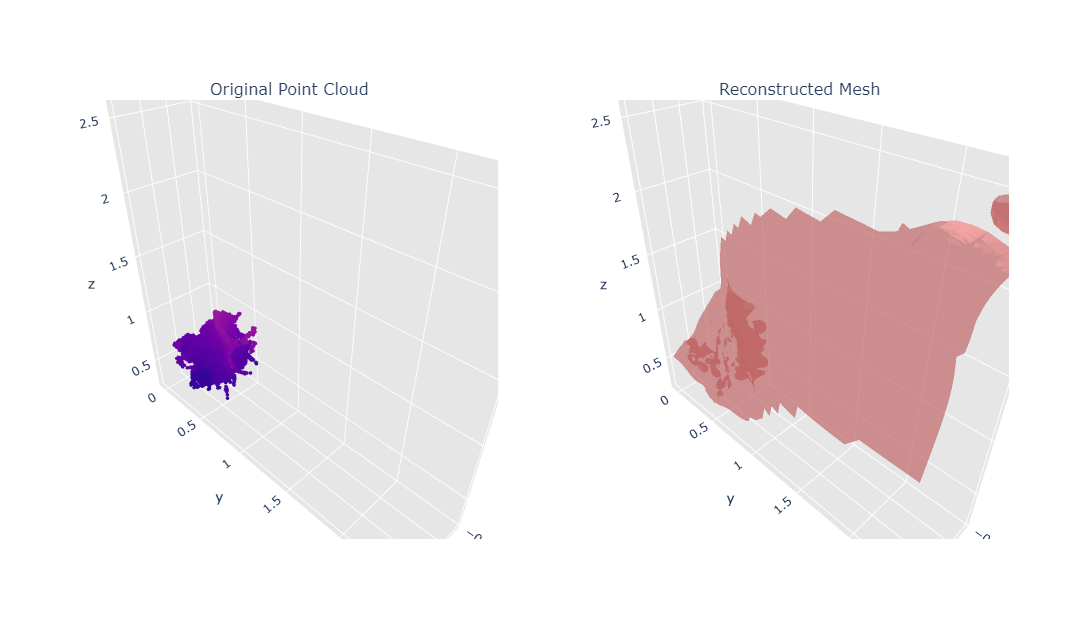

In [19]:
obj = completed_objects[SELECTED_IDX]

if obj.get('mesh'):
    plot_comparison_plotly(obj['mesh'], obj['point_cloud'])
else:
    # Если меша нет, создаем его
    obj['mesh'] = processor.reconstructor.create_mesh(obj['point_cloud'])
    if obj['mesh']:
        plot_comparison_plotly(obj['mesh'], obj['point_cloud'])